In [263]:
library("ggplot2")
library("kableExtra")
library("stringr")
library("FNN")
library("pROC")
library("caret")
library("dplyr")
library("glmnet")
library("rpart")
library("randomForest")
library("partykit")
library("gbm")
library("iml")
library("ROCR")
library("rpart.plot")
library("rockchalk")
library("dummies")
library("MASS")
library("ggpubr")

In [264]:
set.seed(42)

# Exploratory Data Analysis

The dataset provided by the City of Montreal contains 59 fields. The target variable that we will attempt to model is the variable `acc`, which corresponds to the number of pedestrians injured in the last ten years for each intersection. Before fine-tuning our models to predict this variable, we explored the data and removed some aspects from our analyses. The next section presents some examples of this exploratory analysis - complete details and several visualizations are available in the code.

## Data Cleaning

In [265]:
# Importing the data
df <- read.csv("saaq.csv", sep = ";", stringsAsFactors = TRUE, fileEncoding = "UTF-8") # nolint
df[c("X", "X.1")] <- NULL
head(df, 5)

,int_no,x,y,rue_1,rue_2,street_1,street_2,date_,all_pedest,pi,...,any_exclus,commercial,curb_exten,all_red_an,new_half_r,distdt,ln_distdt,traffic_10000,ped_100,borough
,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,40,296397.3,5037515,C^ote-Saint-Antoine,Hampton/Sherbrooke,CPte-Saint-Antoine,Hampton/Sherbrooke,27/02/2009,0,0,...,0,0,0,0,1,3932.077,8.276923,0.2603828,0,CPte-des-Neiges-Notre-Dame-de-Graces
2,263,300293.3,5038406,Centre,Wellington,Centre,Wellington,20/11/2007,0,0,...,0,1,0,0,1,2097.060,7.648292,0.7816052,0,Sud-Ouest
3,1107,301317.1,5039803,Pierre-Dupuy,Habitats 67,Pierre-Dupuy,Habitats 67,09/09/2009,0,0,...,0,2,1,0,0,2112.164,7.655468,0.8896672,0,Ville-Marie
4,1364,299985.9,5037138,Charlevoix,Wellington,Charlevoix,Wellington,10/12/2007,0,0,...,0,0,0,0,0,3172.770,8.062361,1.0932755,0,Sud-Ouest
5,225,297859.8,5036983,Courcelle,Notre-Dame,Courcelle,Notre-Dame,15/11/2006,0,0,...,0,0,0,0,0,3525.406,8.167751,1.0479296,0,Sud-Ouest


Firstly, we removed various variables that I deemed unnecessary for the study:

* `street_1`, `street_2`, `rue_1`, and `rue_2`: Street names are not useful for our models.
* `x` and `y`: The longitude and latitude of intersections are not features that impact accidents (uncorrelated with the variable acc).
* `date_`: Represents the date of recording safety measures and is not related to the accidents themselves.
* `fi` and `ln_fi`: Are linear combinations of other variables (e.g., `fi = fli+fri+fti`) and would cause collinearity problems.
* half_phase: The variable new_half_r replaces this variable by making corrections.

The correclation between longitude and latitude and the target variable acc

In [266]:
cor(df$x, df$acc)
cor(df$y, df$acc)

[1] 0.06187742

[1] -0.002886844

In [267]:
df[c("x", "y", "rue_1", "rue_2", "street_1", "street_2", "date_")] <- NULL
df[c("fi", "ln_fi")] <- NULL

Variables names with `NA` values 

In [268]:
na_index <- colSums(is.na(df)) > 0
print(paste("List of missing variable :", names(df)[na_index]))

[1] "List of missing variable : ln_distdt"


The variable `ln_distdt` (the logarithm of the distance to downtown) has a missing value because it is the `log(0)` for an observation. Therefore, we replace it with the value `0`.

The `ln_distdt` is a log transformation of `distft`

In [269]:
df["ln_distdt"][is.na(df["ln_distdt"])] <- 0

In the provided data, several variables are transformations of another data provided by the City. For example, the variable `ln_fli` is the logarithm of the variable `fli`. We compared their correlation with the variable `acc` to retain only one version of each of these "pairs" of data. We kept the non-transformed values for one group of variables `(cli, cri, cti)`, and for the other group, we retained the transformed values `(ln_pi, ln_fli, ln_fri, ln_fti, ln_distdt)`.

In [270]:
# Numric variables with log transformation
reg_col <- c("pi", "fli", "fri", "fti", "cli", "cri", "cti", "distdt")
log_col <- c("ln_pi", "ln_fli", "ln_fri", "ln_fti", "ln_cli", "ln_cri", "ln_cti", "ln_distdt") # nolint
reg_log_col <- c(reg_col, log_col)

# Data frame with regular and log transformation
df_num <- data.frame(df[reg_log_col])
# Correlation between the columns and the acc variable
cor_acc <- as.data.frame(cor(df[reg_log_col], df["acc"]))
names(cor_acc) <- ("Correlation with acc")
cor_acc

,Correlation with acc
,<dbl>
pi,0.3694418
fli,0.1221749
fri,0.1379657
fti,0.2439317
cli,0.3589527
cri,0.3923028
cti,0.4861139
distdt,-0.1303848
ln_pi,0.3821096


In [271]:
# Remove the unused variables
df[, c("pi", "fli", "fri", "fti", "ln_cli", "ln_cri", "ln_cti", "distdt",
                                                  "traffic_10000", "ped_100")] <- NULL # nolint

Finally, we transformed the categorical variable `borough` which represents in which neighborhood each intersection is located. All neighborhoods with fewer than 20 observations were grouped into a category called `Other`

In [272]:
unique(df["borough"])

,borough
,<fct>
1,CPte-des-Neiges-Notre-Dame-de-Graces
2,Sud-Ouest
3,Ville-Marie
6,Verdun
7,Mercier-Hochelaga-Maisonneuve
11,Rosemont-La-Petite-Patrie
12,Anjou
14,Lasalle
17,Plateau-Mont-Royal


In [273]:
# Clean bourough text
df["borough"] <- gsub("\'U", "e", df[, "borough"])
df["borough"] <- gsub("CPte", "Cote", df[, "borough"])
df["borough"] <- gsub("RiviThres", "Rivieres", df[, "borough"])
df["borough"] <- gsub("GeneviThve", "Genevieve", df[, "borough"])

# Convert string to factor
df["borough"] <- as.factor(df[, "borough"])

x <- table(df["borough"])
df["borough"] <- combineLevels(df[, "borough"], levs = names(x)[x < 20], newLabel = c("Other")) # nolint

The original levels ?le-Bizard-Sainte-Genevieve Ahuntsic-Cartierville Anjou Beaconsfield Cote-Saint-Luc Cote-des-Neiges-Notre-Dame-de-Graces Dollard-des-Ormeaux Dorval Hampstead Kirkland Lachine Lasalle Mercier-Hochelaga-Maisonneuve Mont-Royal Montreal-Est Montreal-Nord Outremont Pierrefonds-Roxboro Plateau-Mont-Royal Pointe-aux-Trembles-Rivieres-des-Prairies Rosemont-La-Petite-Patrie Saint-Laurent St-Leonard Sud-Ouest Verdun Ville-Marie Villeray-Saint-Michel-Parc-Extension Westmount 
have been replaced by Ahuntsic-Cartierville Cote-des-Neiges-Notre-Dame-de-Graces Lasalle Mercier-Hochelaga-Maisonneuve Montreal-Nord Outremont Pierrefonds-Roxboro Plateau-Mont-Royal Pointe-aux-Trembles-Rivieres-des-Prairies Rosemont-La-Petite-Patrie Saint-Laurent St-Leonard Sud-Ouest Ville-Marie Villeray-Saint-Michel-Parc-Extension Other 


In [274]:
unique(df["borough"])

,borough
,<fct>
1,Cote-des-Neiges-Notre-Dame-de-Graces
2,Sud-Ouest
3,Ville-Marie
6,Other
7,Mercier-Hochelaga-Maisonneuve
11,Rosemont-La-Petite-Patrie
14,Lasalle
17,Plateau-Mont-Royal
22,Saint-Laurent


## Exploration des données

During the exploratory data analysis, we visualized the distribution of the variable `acc`. We observed that the distribution of this variable exhibits a strong right skew, and no pedestrian was injured at a large number of intersections. The most dangerous intersection experienced `29` accidents.

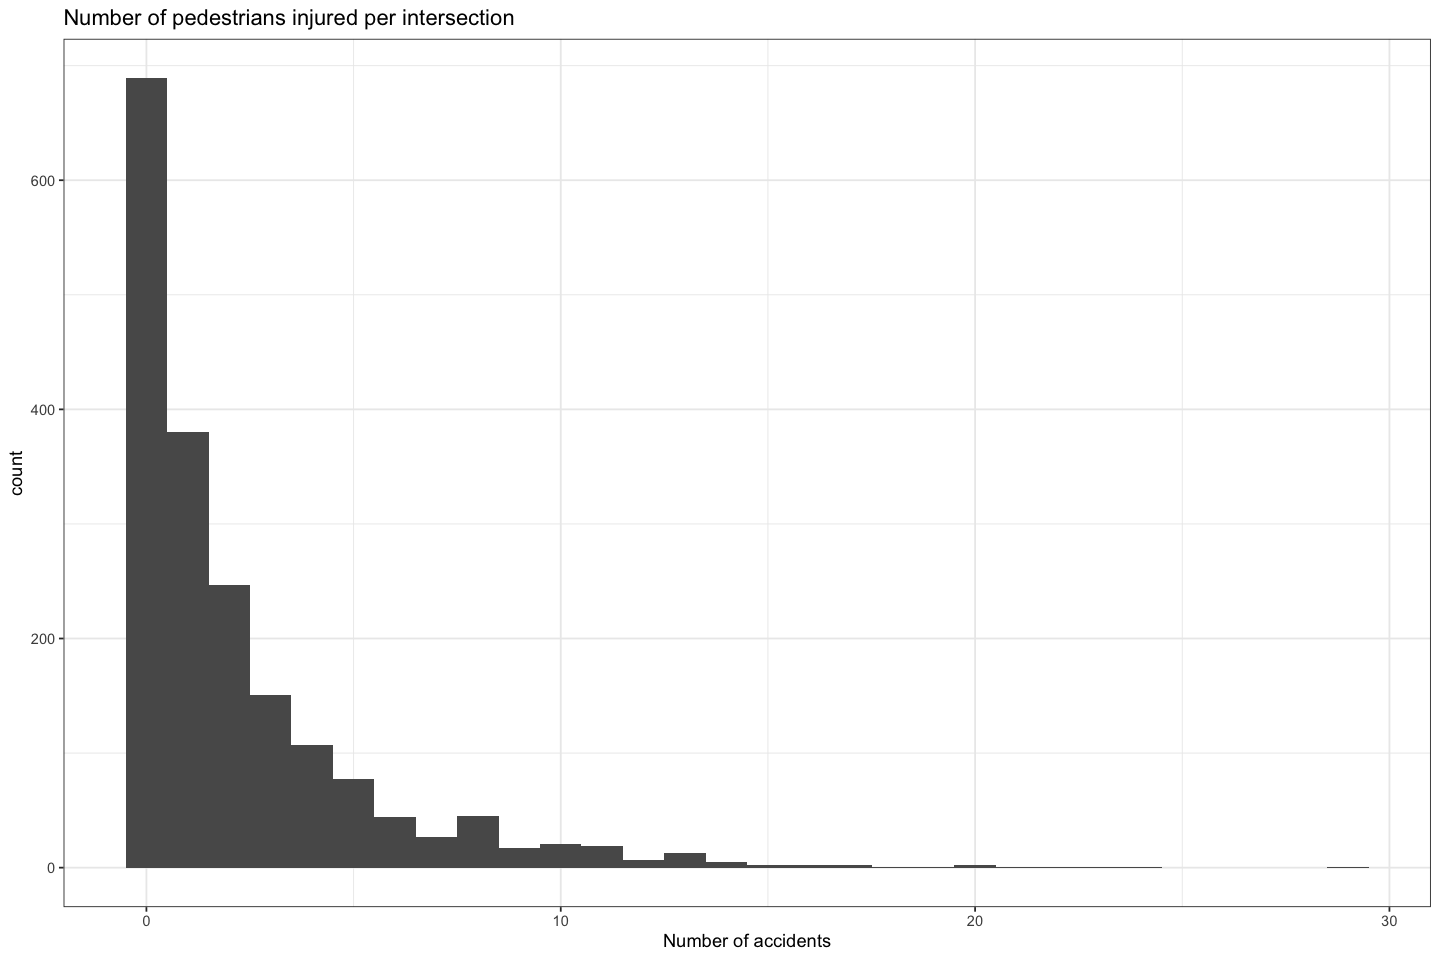

In [296]:
# Visualization of the distribution of the number of accidents
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(df, aes(x = acc)) + geom_histogram(bins = 30) +
  labs(title = "Number of pedestrians injured per intersection", x = "Number of accidents") + # nolint
  theme_bw()

Number of accidents per neighborhoods in Montreal

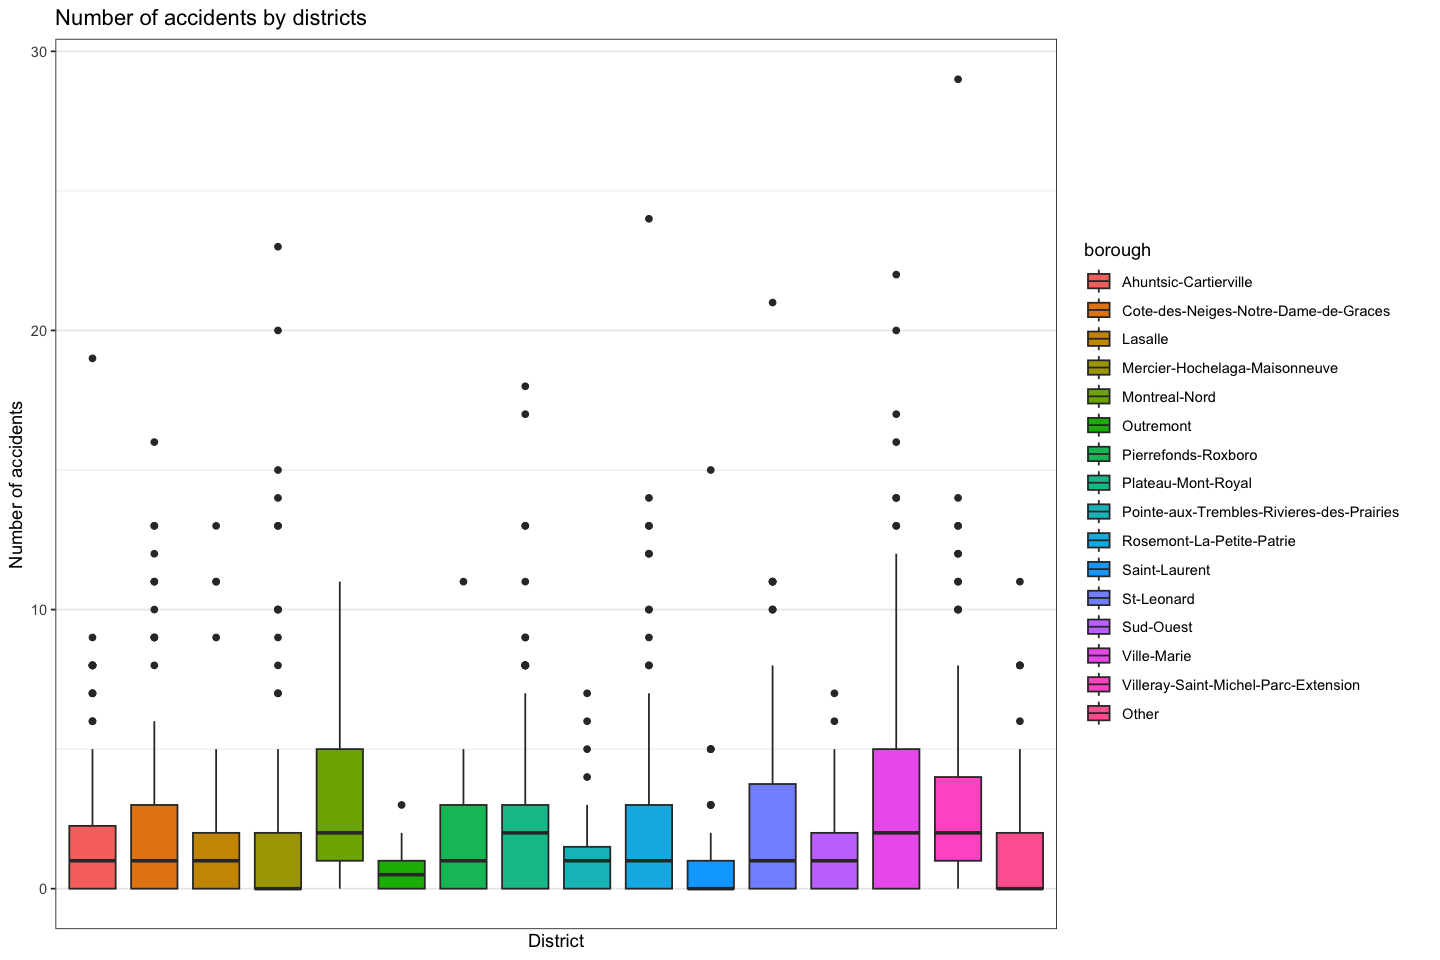

In [294]:
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(df, aes(x = borough, y = acc, fill = borough)) +
  geom_boxplot() +
  labs(title = "Number of accidents by districts", x = "District", y = "Number of accidents") + # nolint
  scale_x_discrete(labels = NULL, breaks = NULL) +
  theme_bw()

According to the boxplot, we observe that the number of accidents varies depending on the district.